In [3]:
from typing import Tuple
import os
import time
import random
import zipfile
from pathlib import Path
import math
import operator
from itertools import cycle
from functools import reduce
from tqdm import trange

from PIL import Image
from tqdm import trange, tqdm
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms


import math
import operator
from itertools import cycle
from functools import reduce
from tqdm import trange
from dataclasses import dataclass


from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = 2
LR = 5e-5
TRAINING_STEPS = 10000
EPOCHS = 50
GAMMA = 0.7

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
image_path = Path("data/")

start_time = time.time()
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    print("Unzipping clinical images...")
    zip_ref.extractall(image_path)
print(f"Unzipping completed in {time.time() - start_time:.2f} seconds.")

Unzipping clinical images...
Unzipping completed in 10.83 seconds.


In [7]:
!mv data/TEST_dataset/ data/test/
!mv data/TR_dataset/ data/train/
!rm -rf data/__MACOSX/

In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

Random image path: data/train/diabetes/04031.bmp
Image class: diabetes
Image height: 384
Image width: 384


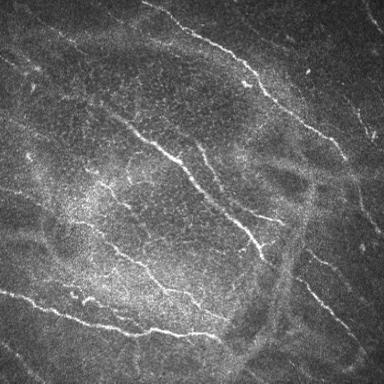

In [9]:
image_path_list = list(image_path.glob("*/*/*.bmp"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

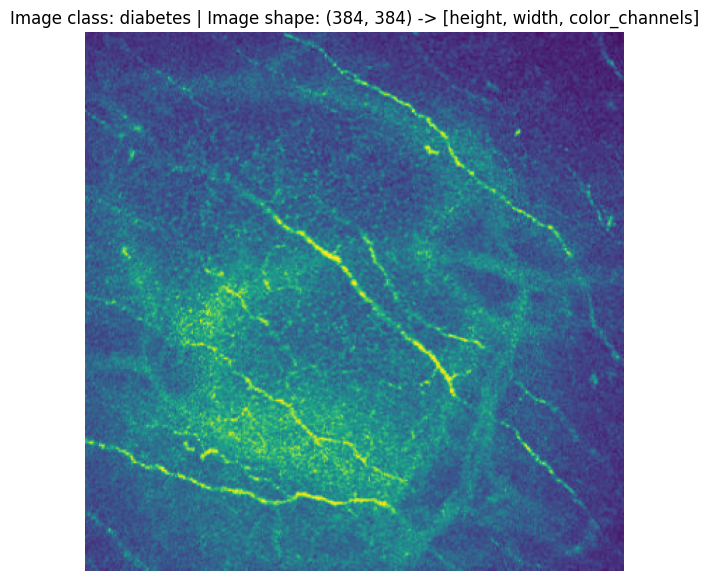

In [10]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [11]:
transform = transforms.Compose([
    # transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [12]:
train_dataset= datasets.ImageFolder(root=train_dir, transform=transform, target_transform=None)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

print(f"Train data:\n{train_dataset}\nTest data:\n{test_dataset}")

Train data:
Dataset ImageFolder
    Number of datapoints: 10888
    Root location: data/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 4313
    Root location: data/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [13]:
class_names = train_dataset.classes
class_dict = train_dataset.class_to_idx
class_names, class_dict

(['control', 'diabetes'], {'control': 0, 'diabetes': 1})

In [14]:
for i, (img, label) in enumerate(train_dataset):
    print(i, img.size(), label)

    if i == 3:
        break

0 torch.Size([3, 384, 384]) 0
1 torch.Size([3, 384, 384]) 0
2 torch.Size([3, 384, 384]) 0
3 torch.Size([3, 384, 384]) 0


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [16]:
@dataclass
class ModelConfig:
    hidden_size: int
    n_heads: int
    n_layers: int
    mlp_size: int
    attn_dropout: float
    mlp_dropout: float
    qkv_bias: bool

    n_classes: int
    channels: int
    patch_size: int
    img_size: int
    height: int
    width: int

In [17]:
class PatchEmbedding(nn.Module):

    def __init__(self, model_config: ModelConfig) -> None:
        super().__init__()

        self.patcher = nn.Conv2d(
            in_channels= model_config.channels,
            out_channels = model_config.hidden_size,
            kernel_size=model_config.patch_size,
            stride=model_config.patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(
            start_dim=2, # only flatten the feature map dimensions into a single vector
            end_dim=3
        )

        self.patch_size = model_config.patch_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # (batch_size, channel, height, width)
        image_resolution = x.shape[-1]

        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size."

        # (batch_size, channel, height, width) -> (batch_size, hidden_size, height / patch_size, width / patch_size)
        # hidden_size = patch_size * patch_size * channels
        x_patched = self.patcher(x)

        # (batch_size, hidden_size, height / patch_size, width / patch_size) -> (batch_size, hidden_size, height / patch_size * width / patch_size)
        # patches_num = height / patch_size * width / patch_size
        x_flattened = self.flatten(x_patched)

        # also called seq length
        # (batch_size, hidden_size, patches_num x patches_num) -> (batch_size, patches_num x patches_num, hidden_size),
        x_permuted = x_flattened.permute(0, 2, 1)

        return x_permuted

In [18]:
class MultiHeadAttention(nn.Module):

    def __init__(self, model_config: ModelConfig) -> None:
        super().__init__()

        self.ln = nn.LayerNorm(model_config.hidden_size)

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=model_config.hidden_size,
            num_heads=model_config.n_heads,
            dropout=model_config.attn_dropout,
            batch_first=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.ln(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [19]:
class MLP(nn.Module):
    def __init__(self, model_config: ModelConfig) -> None:
        super().__init__()

        self.ln = nn.LayerNorm(model_config.hidden_size)

        self.mlp = nn.Sequential(
            nn.Linear(in_features = model_config.hidden_size, out_features = model_config.mlp_size),
            nn.GELU(),
            nn.Dropout(model_config.mlp_dropout),
            nn.Linear(in_features = model_config.mlp_size, out_features = model_config.hidden_size),
            nn.Dropout(model_config.mlp_dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.ln(x)
        x = self.mlp(x)
        return x


In [20]:
class Encoder(nn.Module):
    def __init__(self, model_config: ModelConfig) -> None:
        super().__init__()

        self.msa = MultiHeadAttention(model_config)
        self.mlp =  MLP(model_config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x =  self.msa(x) + x
        x = self.mlp(x) + x
        return x

In [21]:
class ViT(nn.Module):
    def __init__(self, model_config: ModelConfig) -> None:
        super().__init__()

        assert model_config.img_size % model_config.patch_size == 0, f"Image size must be divisible by patch size."

        self.num_patches = (model_config.img_size * model_config.img_size) // model_config.patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, model_config.hidden_size), requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, model_config.hidden_size), requires_grad=True)

        self.patch_embedding = PatchEmbedding(model_config)

        self.transformer_encoder = nn.Sequential(
            *[
                Encoder(model_config)
                for _ in range(model_config.n_layers)
            ]
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(model_config.hidden_size),
            nn.Linear(model_config.hidden_size, model_config.n_classes)
        )

    def forward(self, x):

        batch_size = x.shape[0]

        # expand to match the batch size, "-1" infer dimension
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [22]:
model_variants = {
    'tiny': { 'n_layers': 3, 'hidden_size': 192, 'mlp_size': 768, 'n_heads': 3, 'attn_dropout' : 0.0, 'mlp_dropout' : 0.1, 'qkv_bias' : False },
    'small': { 'n_layers': 12, 'hidden_size': 384, 'mlp_size': 3072, 'n_heads': 6, 'attn_dropout' : 0.0, 'mlp_dropout' : 0.1, 'qkv_bias' : False },
    'base': { 'n_layers': 12, 'hidden_size': 768, 'mlp_size': 3072, 'n_heads': 12, 'attn_dropout' : 0.0, 'mlp_dropout' : 0.1, 'qkv_bias' : False },
    'large': { 'n_layers': 24, 'hidden_size': 1024, 'mlp_size': 4096, 'n_heads': 16, 'attn_dropout' : 0.0, 'mlp_dropout' : 0.1, 'qkv_bias' : False },
    'huge': { 'n_layers': 32, 'hidden_size': 1280, 'mlp_size': 5120, 'n_heads': 16, 'attn_dropout' : 0.0, 'mlp_dropout' : 0.1, 'qkv_bias' : False }
}

In [23]:
dataset_params = { "n_classes": 2, "channels": 3, "patch_size": 16, "img_size": 384, "height": 384, "width": 384}

In [24]:
model_config = model_variants.get("small")

In [25]:
config = ModelConfig(
            n_layers = model_config['n_layers'],
            hidden_size = model_config['hidden_size'],
            mlp_size = model_config['mlp_size'],
            n_heads = model_config['n_heads'],
            attn_dropout = model_config['attn_dropout'],
            mlp_dropout = model_config['mlp_dropout'],
            qkv_bias = model_config['qkv_bias'],
            **dataset_params
        )

In [26]:
import gc
# del model
gc.collect()
torch.cuda.empty_cache()

In [27]:
model = ViT(config)

In [28]:
summary(model, input_size=[BATCH_SIZE, 3, 384, 384])

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [32, 2]                   221,952
├─PatchEmbedding: 1-1                         [32, 576, 384]            --
│    └─Conv2d: 2-1                            [32, 384, 24, 24]         295,296
│    └─Flatten: 2-2                           [32, 384, 576]            --
├─Sequential: 1-2                             [32, 577, 384]            --
│    └─Encoder: 2-3                           [32, 577, 384]            --
│    │    └─MultiHeadAttention: 3-1           [32, 577, 384]            592,128
│    │    └─MLP: 3-2                          [32, 577, 384]            2,363,520
│    └─Encoder: 2-4                           [32, 577, 384]            --
│    │    └─MultiHeadAttention: 3-3           [32, 577, 384]            592,128
│    │    └─MLP: 3-4                          [32, 577, 384]            2,363,520
│    └─Encoder: 2-5                           [32, 577, 384] 

In [30]:
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [31]:
def train_step(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [32]:
def test_step(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
) -> Tuple[float, float]:

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [33]:
def train(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
) -> None:

    model.to(device)

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
                                    model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device
                                )

        test_loss, test_acc = test_step(
                                    model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device
                                )

        print(
          f" Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [34]:
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, EPOCHS, device)

  2%|▏         | 1/50 [02:17<1:52:27, 137.71s/it]

 Epoch: 1 | train_loss: 0.7117 | train_acc: 0.5105 | test_loss: 0.6024 | test_acc: 0.8505


  4%|▍         | 2/50 [04:35<1:49:58, 137.47s/it]

 Epoch: 2 | train_loss: 0.6976 | train_acc: 0.5187 | test_loss: 0.7174 | test_acc: 0.3765


  6%|▌         | 3/50 [06:52<1:47:40, 137.47s/it]

 Epoch: 3 | train_loss: 0.6907 | train_acc: 0.5318 | test_loss: 0.6169 | test_acc: 0.8148


  8%|▊         | 4/50 [09:09<1:45:21, 137.43s/it]

 Epoch: 4 | train_loss: 0.6852 | train_acc: 0.5560 | test_loss: 0.6123 | test_acc: 0.7394


 10%|█         | 5/50 [11:27<1:43:05, 137.46s/it]

 Epoch: 5 | train_loss: 0.6731 | train_acc: 0.5806 | test_loss: 0.5359 | test_acc: 0.8102


 12%|█▏        | 6/50 [13:44<1:40:47, 137.44s/it]

 Epoch: 6 | train_loss: 0.6605 | train_acc: 0.6017 | test_loss: 0.5330 | test_acc: 0.8007


 14%|█▍        | 7/50 [16:02<1:38:30, 137.46s/it]

 Epoch: 7 | train_loss: 0.6493 | train_acc: 0.6162 | test_loss: 0.5874 | test_acc: 0.7551


 16%|█▌        | 8/50 [18:19<1:36:14, 137.49s/it]

 Epoch: 8 | train_loss: 0.6395 | train_acc: 0.6265 | test_loss: 0.6211 | test_acc: 0.6903


 18%|█▊        | 9/50 [20:37<1:33:57, 137.49s/it]

 Epoch: 9 | train_loss: 0.6226 | train_acc: 0.6482 | test_loss: 0.6934 | test_acc: 0.5842


 20%|██        | 10/50 [22:54<1:31:39, 137.48s/it]

 Epoch: 10 | train_loss: 0.6053 | train_acc: 0.6684 | test_loss: 0.6284 | test_acc: 0.6741


 22%|██▏       | 11/50 [25:12<1:29:22, 137.49s/it]

 Epoch: 11 | train_loss: 0.5836 | train_acc: 0.6877 | test_loss: 0.6381 | test_acc: 0.6736


 24%|██▍       | 12/50 [27:29<1:27:05, 137.50s/it]

 Epoch: 12 | train_loss: 0.5596 | train_acc: 0.7082 | test_loss: 0.6183 | test_acc: 0.6928


 26%|██▌       | 13/50 [29:47<1:24:47, 137.50s/it]

 Epoch: 13 | train_loss: 0.5294 | train_acc: 0.7333 | test_loss: 0.6803 | test_acc: 0.6694


 28%|██▊       | 14/50 [32:04<1:22:30, 137.50s/it]

 Epoch: 14 | train_loss: 0.4994 | train_acc: 0.7548 | test_loss: 0.6151 | test_acc: 0.7012


 30%|███       | 15/50 [34:22<1:20:12, 137.50s/it]

 Epoch: 15 | train_loss: 0.4605 | train_acc: 0.7837 | test_loss: 0.7237 | test_acc: 0.6522


 32%|███▏      | 16/50 [36:39<1:17:55, 137.51s/it]

 Epoch: 16 | train_loss: 0.4148 | train_acc: 0.8079 | test_loss: 0.7402 | test_acc: 0.6981


 34%|███▍      | 17/50 [38:57<1:15:37, 137.50s/it]

 Epoch: 17 | train_loss: 0.3649 | train_acc: 0.8336 | test_loss: 1.0998 | test_acc: 0.5222


 36%|███▌      | 18/50 [41:14<1:13:20, 137.50s/it]

 Epoch: 18 | train_loss: 0.3168 | train_acc: 0.8561 | test_loss: 1.3913 | test_acc: 0.5102


 38%|███▊      | 19/50 [43:32<1:11:04, 137.55s/it]

 Epoch: 19 | train_loss: 0.2724 | train_acc: 0.8823 | test_loss: 1.1061 | test_acc: 0.5844


 40%|████      | 20/50 [45:50<1:08:46, 137.55s/it]

 Epoch: 20 | train_loss: 0.2456 | train_acc: 0.8986 | test_loss: 1.1375 | test_acc: 0.6080


 42%|████▏     | 21/50 [48:07<1:06:29, 137.56s/it]

 Epoch: 21 | train_loss: 0.2081 | train_acc: 0.9148 | test_loss: 1.0172 | test_acc: 0.6157


 44%|████▍     | 22/50 [50:25<1:04:10, 137.53s/it]

 Epoch: 22 | train_loss: 0.1812 | train_acc: 0.9275 | test_loss: 1.4429 | test_acc: 0.5988


 46%|████▌     | 23/50 [52:42<1:01:53, 137.53s/it]

 Epoch: 23 | train_loss: 0.1580 | train_acc: 0.9369 | test_loss: 1.7748 | test_acc: 0.5598


 48%|████▊     | 24/50 [55:00<59:36, 137.55s/it]  

 Epoch: 24 | train_loss: 0.1347 | train_acc: 0.9475 | test_loss: 1.6579 | test_acc: 0.6127


 50%|█████     | 25/50 [57:17<57:19, 137.57s/it]

 Epoch: 25 | train_loss: 0.1327 | train_acc: 0.9489 | test_loss: 1.7226 | test_acc: 0.6065


 52%|█████▏    | 26/50 [59:35<55:01, 137.55s/it]

 Epoch: 26 | train_loss: 0.1100 | train_acc: 0.9578 | test_loss: 1.9147 | test_acc: 0.5310


 54%|█████▍    | 27/50 [1:01:52<52:43, 137.54s/it]

 Epoch: 27 | train_loss: 0.1035 | train_acc: 0.9611 | test_loss: 1.7632 | test_acc: 0.5513


 56%|█████▌    | 28/50 [1:04:10<50:26, 137.57s/it]

 Epoch: 28 | train_loss: 0.0988 | train_acc: 0.9648 | test_loss: 1.5531 | test_acc: 0.6329


 58%|█████▊    | 29/50 [1:06:27<48:08, 137.55s/it]

 Epoch: 29 | train_loss: 0.0957 | train_acc: 0.9639 | test_loss: 1.4979 | test_acc: 0.5746


 60%|██████    | 30/50 [1:08:45<45:51, 137.57s/it]

 Epoch: 30 | train_loss: 0.0900 | train_acc: 0.9643 | test_loss: 2.1915 | test_acc: 0.5452


 62%|██████▏   | 31/50 [1:11:03<43:33, 137.53s/it]

 Epoch: 31 | train_loss: 0.0793 | train_acc: 0.9720 | test_loss: 1.8253 | test_acc: 0.5677


 64%|██████▍   | 32/50 [1:13:20<41:16, 137.57s/it]

 Epoch: 32 | train_loss: 0.0695 | train_acc: 0.9740 | test_loss: 1.9969 | test_acc: 0.5872


 66%|██████▌   | 33/50 [1:15:38<38:58, 137.59s/it]

 Epoch: 33 | train_loss: 0.0843 | train_acc: 0.9680 | test_loss: 1.9388 | test_acc: 0.5427


 68%|██████▊   | 34/50 [1:17:55<36:41, 137.60s/it]

 Epoch: 34 | train_loss: 0.0692 | train_acc: 0.9735 | test_loss: 2.0918 | test_acc: 0.5741


 70%|███████   | 35/50 [1:20:13<34:24, 137.60s/it]

 Epoch: 35 | train_loss: 0.0736 | train_acc: 0.9715 | test_loss: 2.3761 | test_acc: 0.6177


 72%|███████▏  | 36/50 [1:22:31<32:06, 137.59s/it]

 Epoch: 36 | train_loss: 0.0822 | train_acc: 0.9685 | test_loss: 2.4244 | test_acc: 0.5025


 74%|███████▍  | 37/50 [1:24:48<29:48, 137.58s/it]

 Epoch: 37 | train_loss: 0.0607 | train_acc: 0.9772 | test_loss: 2.0095 | test_acc: 0.6215


 76%|███████▌  | 38/50 [1:27:06<27:31, 137.59s/it]

 Epoch: 38 | train_loss: 0.0601 | train_acc: 0.9765 | test_loss: 2.4739 | test_acc: 0.5431


 78%|███████▊  | 39/50 [1:29:23<25:13, 137.59s/it]

 Epoch: 39 | train_loss: 0.0597 | train_acc: 0.9765 | test_loss: 1.9696 | test_acc: 0.6039


 80%|████████  | 40/50 [1:31:41<22:55, 137.59s/it]

 Epoch: 40 | train_loss: 0.0728 | train_acc: 0.9730 | test_loss: 1.6504 | test_acc: 0.6497


 82%|████████▏ | 41/50 [1:33:59<20:38, 137.60s/it]

 Epoch: 41 | train_loss: 0.0644 | train_acc: 0.9740 | test_loss: 1.7114 | test_acc: 0.6534


 84%|████████▍ | 42/50 [1:36:16<18:20, 137.60s/it]

 Epoch: 42 | train_loss: 0.0523 | train_acc: 0.9799 | test_loss: 2.3380 | test_acc: 0.5915


 86%|████████▌ | 43/50 [1:38:34<16:03, 137.59s/it]

 Epoch: 43 | train_loss: 0.0569 | train_acc: 0.9789 | test_loss: 2.2578 | test_acc: 0.5789


 88%|████████▊ | 44/50 [1:40:51<13:45, 137.62s/it]

 Epoch: 44 | train_loss: 0.0531 | train_acc: 0.9797 | test_loss: 2.2531 | test_acc: 0.5157


 90%|█████████ | 45/50 [1:43:09<11:27, 137.59s/it]

 Epoch: 45 | train_loss: 0.0507 | train_acc: 0.9798 | test_loss: 2.3226 | test_acc: 0.5611


 92%|█████████▏| 46/50 [1:45:27<09:10, 137.58s/it]

 Epoch: 46 | train_loss: 0.0544 | train_acc: 0.9809 | test_loss: 1.9601 | test_acc: 0.5944


 94%|█████████▍| 47/50 [1:47:44<06:52, 137.58s/it]

 Epoch: 47 | train_loss: 0.0517 | train_acc: 0.9797 | test_loss: 2.0587 | test_acc: 0.6004


 96%|█████████▌| 48/50 [1:50:02<04:35, 137.62s/it]

 Epoch: 48 | train_loss: 0.0487 | train_acc: 0.9815 | test_loss: 2.0802 | test_acc: 0.6138


 98%|█████████▊| 49/50 [1:52:19<02:17, 137.62s/it]

 Epoch: 49 | train_loss: 0.0552 | train_acc: 0.9764 | test_loss: 2.2074 | test_acc: 0.5875


100%|██████████| 50/50 [1:54:37<00:00, 137.55s/it]

 Epoch: 50 | train_loss: 0.0582 | train_acc: 0.9785 | test_loss: 1.9851 | test_acc: 0.5732


In [35]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

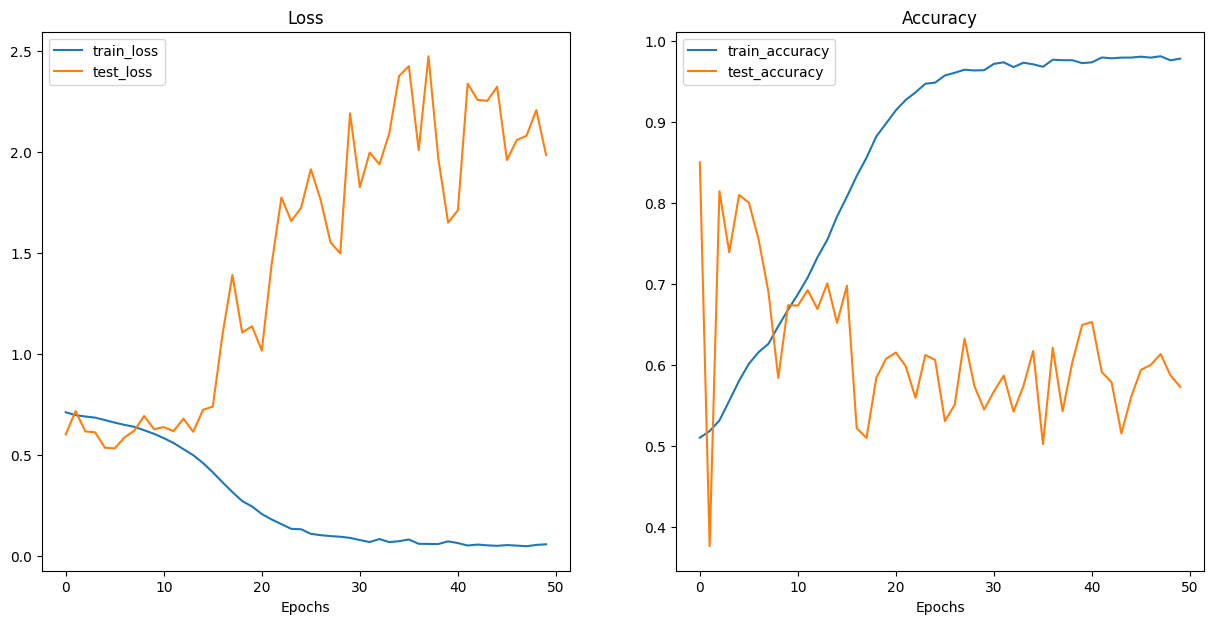

In [36]:
plot_loss_curves(results)

In [37]:
torch.save(obj=model.state_dict(), f="vit_v1.pth")